In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.base import clone
from sklearn.linear_model import Ridge 
from sklearn.metrics import make_scorer
import lightgbm as lgb
import catboost as cb
import xgboost as xgb
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")

#### Config
LightGBM, CatBoost, and XGBoost—each set up to output the lower and upper quantiles that form a 90 % prediction interval.

In [4]:
MODEL_NAMES = ["LightGBM", "CatBoost", "XGBoost"]

MODELS = {
    "LightGBM": {
        "lower": lgb.LGBMRegressor(objective="quantile", alpha=0.05, device="gpu", n_estimators=1500,
                                 learning_rate=0.05, num_leaves=60, max_depth=9, min_child_samples=30,
                                 subsample=0.8, random_state=42, n_jobs=8),
        "upper": lgb.LGBMRegressor(objective="quantile", alpha=0.95, device="gpu", n_estimators=1500,
                                 learning_rate=0.05, num_leaves=60, max_depth=9, min_child_samples=30,
                                 subsample=0.8, random_state=42, n_jobs=8)
    },
    "CatBoost": cb.CatBoostRegressor(loss_function="RMSEWithUncertainty", task_type="GPU", iterations=1500,
                                   learning_rate=0.05, depth=8, l2_leaf_reg=5, min_data_in_leaf=30,
                                   verbose=0, random_seed=42, thread_count=4),
    "XGBoost": {
        "lower": xgb.XGBRegressor(objective="reg:quantileerror", quantile_alpha=0.05, tree_method="gpu_hist",
                                n_estimators=1500, learning_rate=0.05, max_depth=8, min_child_weight=50,
                                subsample=0.8, random_state=42, n_jobs=8),
        "upper": xgb.XGBRegressor(objective="reg:quantileerror", quantile_alpha=0.95, tree_method="gpu_hist",
                                n_estimators=1500, learning_rate=0.05, max_depth=8, min_child_weight=50,
                                subsample=0.8, random_state=42, n_jobs=8)
    }
}

 #### Feature Engineering
- 時間特徵
    - sale_year：交易年份
    - sale_month：交易月份
- 價值組合
    - total_val = land_val + imp_val（總評定值）
    - land_ratio = land_val / total_val（土地占比）
    - imp_ratio = imp_val / total_val（建物占比）
- 屋況 / 面積
    - total_baths：等效浴室數＝full + 0.75·3qtr + 0.5·half
    - sqft_area = sqft + sqft_fbsmt（地上 + 半地下坪）
    - house_age = sale_year − year_built
    - years_since_reno：距上次整修年數（無整修則 0）
- 景觀指標
    - view_score：10 個 view_* 欄位總和
- 空間分箱
    - 將 latitude、longitude 各做 50 分位等頻切分 → lat_bin, lon_bin
    - lat_lon_bin = lat_bin + '_' + lon_bin（50×50 網格 ID）

In [ ]:
def preprocess_data(df, is_train=True, encoder=None):
    df = df.copy()
    df['sale_date'] = pd.to_datetime(df['sale_date'])
    df['sale_year'] = df['sale_date'].dt.year
    df['sale_month'] = df['sale_date'].dt.month

    df['total_val'] = df['land_val'] + df['imp_val']
    df['land_ratio'] = df['land_val'] / df['total_val'].replace(0, np.nan)
    df['imp_ratio'] = df['imp_val'] / df['total_val'].replace(0, np.nan)
    df['total_baths'] = df['bath_full'] + 0.75 * df['bath_3qtr'] + 0.5 * df['bath_half']
    df['sqft_area'] = df['sqft'] + df['sqft_fbsmt']
    df['house_age'] = df['sale_year'] - df['year_built']
    df['years_since_reno'] = np.where(df['year_reno'] > 0, df['sale_year'] - df['year_reno'], 0)

    view_cols = ['view_rainier', 'view_olympics', 'view_cascades', 'view_territorial',
                 'view_skyline', 'view_sound', 'view_lakewash', 'view_lakesamm',
                 'view_otherwater', 'view_other']
    df['view_score'] = df[view_cols].sum(axis=1)
    
    df['lat_bin'] = pd.qcut(df['latitude'], q=50, labels=False, duplicates='drop')
    df['lon_bin'] = pd.qcut(df['longitude'], q=50, labels=False, duplicates='drop')
    df['lat_lon_bin'] = df['lat_bin'].astype(str) + '_' + df['lon_bin'].astype(str)
    
    cat_cols = ['sale_warning', 'join_status', 'city', 'zoning', 'lat_lon_bin']
    df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0]).astype('category')
    
    # encode categorical variables
    if is_train:
        encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
        df[cat_cols] = encoder.fit_transform(df[cat_cols])
        return df.drop(columns=['sale_date', 'id', 'lat_bin', 'lon_bin'], errors='ignore'), cat_cols, encoder
    else:
        df[cat_cols] = encoder.transform(df[cat_cols])
        return df.drop(columns=['sale_date', 'id', 'lat_bin', 'lon_bin'], errors='ignore'), cat_cols, encoder

#### Interval Score

In [6]:
def winkler_score(y_true, lower, upper, alpha = 0.10):
    width = upper - lower
    below = np.maximum(lower - y_true, 0)
    above = np.maximum(y_true - upper, 0)
    return width + (2/alpha) * (below + above)

#### Training Function

In [ ]:
def train_and_predict(model, X_train, y_train, X_val, z_score=1.645):
    if isinstance(model, dict):  # for lgb and xgb
        lower_model = clone(model["lower"]).fit(X_train, y_train)
        upper_model = clone(model["upper"]).fit(X_train, y_train)
        return lower_model.predict(X_val), upper_model.predict(X_val)
    else:  # for CatBoost
        model = clone(model).fit(X_train, y_train)
        preds = model.predict(X_val)
        means, stds = preds[:, 0], np.sqrt(preds[:, 1])
        return means - z_score * stds, means + z_score * stds

In [ ]:
def cross_validate(X, y, models, n_folds=5):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    pred_lower = {model: np.zeros(len(X)) for model in MODEL_NAMES}
    pred_upper = {model: np.zeros(len(X)) for model in MODEL_NAMES}
    
    for train_idx, val_idx in tqdm(kf.split(X, y), total=n_folds, desc="CV Folds"):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train = y.iloc[train_idx]
        
        for model_name in MODEL_NAMES:
            model = models[model_name]
            lower, upper = train_and_predict(model, X_train, y_train, X_val)
            pred_lower[model_name][val_idx] = lower
            pred_upper[model_name][val_idx] = upper
    
    # evaluate individual models
    for model in MODEL_NAMES:
        coverage = np.mean((y >= pred_lower[model]) & (y <= pred_upper[model]))
        score = np.mean(winkler_score(y, pred_lower[model], pred_upper[model]))
        print(f"{model}: MWIS={score:.4f}, Coverage={coverage:.2%}")
    
    return pred_lower, pred_upper

In [ ]:
def simulated_annealing(y_true, lowers, uppers, model_keys, n_iterations=100, initial_temp=1000, cooling_rate=0.95):
    weights = np.array([1.0 / len(model_keys)] * len(model_keys))
    best_weights, best_score = weights.copy(), float('inf')
    current_weights, current_score = weights.copy(), float('inf')
    temp = initial_temp
    
    for _ in tqdm(range(n_iterations), desc="Simulated Annealing"):
        candidate = np.maximum(current_weights + 0.1 * (np.random.dirichlet([5] * len(model_keys)) - 0.5/3), 0)
        candidate /= candidate.sum()
        
        new_lower = sum(w * lowers[m] for w, m in zip(candidate, model_keys))
        new_upper = sum(w * uppers[m] for w, m in zip(candidate, model_keys))
        score = np.mean(winkler_score(y_true, new_lower, new_upper))
        
        if score < current_score or np.random.rand() < np.exp((current_score - score) / temp):
            current_weights = candidate.copy()
            current_score = score
            if score < best_score:
                best_score = score
                best_weights = candidate.copy()
                print(f"Improved MWIS: {score:.4f}, Weights: {best_weights}")
        
        temp *= cooling_rate
    
    return best_weights, best_score

In [ ]:
def train_stacking_model(lowers, uppers, y_true, model_keys):
    X_stack = np.vstack([lowers[m] for m in model_keys] + [uppers[m] for m in model_keys]).T
    meta_model = Ridge(alpha=1.0).fit(X_stack, y_true) 
    return meta_model

In [ ]:
def predict_with_stacking(meta_model, test_preds_lower, test_preds_upper, model_keys, weights):
    final_lower = sum(w * test_preds_lower[m] for w, m in zip(weights, model_keys))
    final_upper = sum(w * test_preds_upper[m] for w, m in zip(weights, model_keys))
    # ensure intervals valid
    final_lower = np.maximum(final_lower, 10000)  
    final_upper = np.maximum(final_upper, final_lower + 10000)  
    return final_lower, final_upper

#### Model Fitting

In [ ]:
# Load data
train_df = pd.read_csv('dataset.csv').drop(columns=["submarket", "subdivision", "sale_nbr"], errors='ignore')
test_df = pd.read_csv('test.csv').drop(columns=["submarket", "subdivision", "sale_nbr"], errors='ignore')

# Preprocess
train_df, cat_cols, encoder = preprocess_data(train_df, is_train=True)
X_test, _, _ = preprocess_data(test_df, is_train=False, encoder=encoder)

missing_in_test = set(train_df.columns) - set(X_test.columns) - {'sale_price'}
missing_in_train = set(X_test.columns) - set(train_df.columns)

X, y = train_df.drop(columns=['sale_price'], errors='ignore'), train_df['sale_price']

In [ ]:
# cross validation
pred_lower, pred_upper = cross_validate(X, y, MODELS)

In [45]:
# optimize ensemble
best_weights, best_score = simulated_annealing(y, pred_lower, pred_upper, MODEL_NAMES)

Simulated Annealing:   0%|          | 0/100 [00:00<?, ?it/s]

Improved MWIS: 326427.5975, Weights: [0.32332366 0.35763184 0.3190445 ]
Improved MWIS: 326416.2435, Weights: [0.31071482 0.36857456 0.32071062]
Improved MWIS: 326403.1860, Weights: [0.30437368 0.36624184 0.32938448]
Improved MWIS: 326390.2631, Weights: [0.29600836 0.36191763 0.342074  ]
Improved MWIS: 326388.1416, Weights: [0.2907679  0.35289527 0.35633683]


In [ ]:
# stacking 
meta_model = train_stacking_model(pred_lower, pred_upper, y, MODEL_NAMES)

In [ ]:
# train final models 
test_preds = {"lower": {}, "upper": {}}
for model_name in tqdm(MODEL_NAMES, desc="Final Models"):
    model = MODELS[model_name]
    lower, upper = train_and_predict(model, X, y, X_test)
    test_preds["lower"][model_name] = lower
    test_preds["upper"][model_name] = upper

final_lower, final_upper = predict_with_stacking(meta_model, test_preds["lower"], test_preds["upper"], MODEL_NAMES, best_weights)

Final Models:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4849
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 52
[LightGBM] [Info] Using GPU Device: Tesla V100S-PCIE-32GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 29 dense feature groups (6.10 MB) transferred to GPU in 0.006929 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 185000.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

#### Evaluation

In [49]:
#results
print(f'{"Model":<10}{"MWIS Score":>15}')
print('-' * 25)
print(f'{"Ensemble":<10}{best_score:>15.4f}')

Model          MWIS Score
-------------------------
Ensemble      326388.1416


#### Submission

In [ ]:
submission = pd.DataFrame({
    "id": test_df["id"],
    "pi_lower": final_lower,
    "pi_upper": final_upper
})
submission.to_csv("submission.csv", index=False)

In [53]:
submission.head()  

,id,pi_lower,pi_upper
0,200000,816309.326364,1.135311e+06
1,200001,568574.141710,7.665932e+05
2,200002,462212.073770,6.739633e+05
3,200003,301746.211460,4.372113e+05
4,200004,419298.854147,6.230915e+05


### Visualization

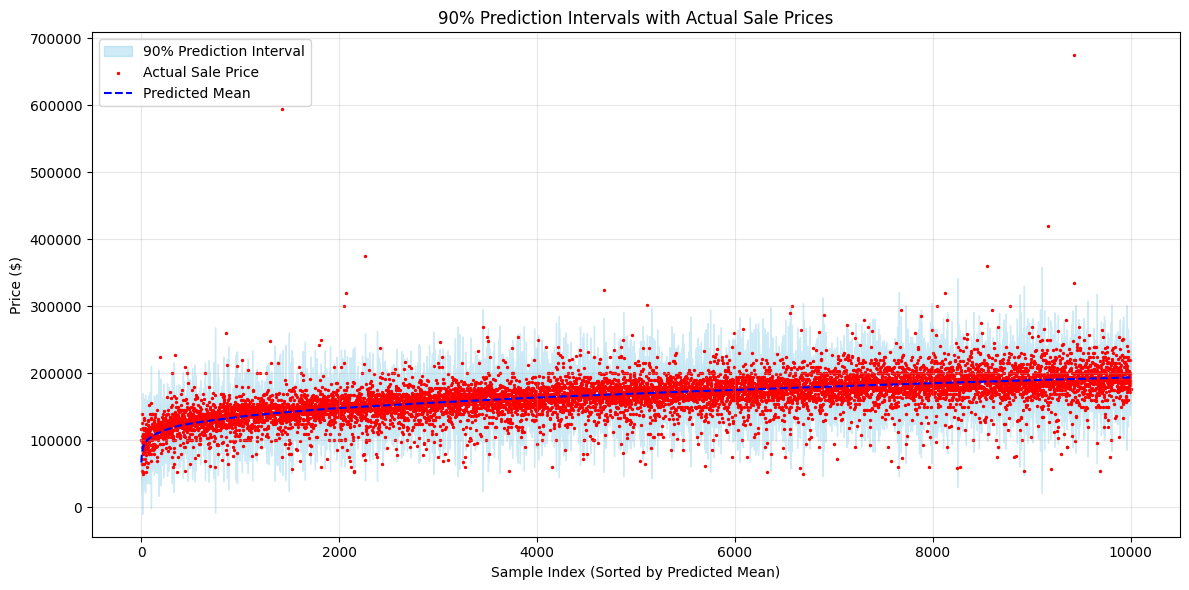

In [ ]:
n_samples=10000
final_lower = sum(w * pred_lower[model] for w, model in zip(best_weights, MODEL_NAMES))
final_upper = sum(w * pred_upper[model] for w, model in zip(best_weights, MODEL_NAMES))
    
pred_mean = (final_lower + final_upper) / 2
indices = np.argsort(pred_mean)[:n_samples]
final_lower = final_lower[indices]
final_upper = final_upper[indices]
y_true = y.iloc[indices].values
    
plt.figure(figsize=(12, 6))
x = np.arange(n_samples)
plt.fill_between(x, final_lower, final_upper, color='skyblue', alpha=0.4, label='90% Prediction Interval')
plt.scatter(x, y_true, color='red', s=2, label='Actual Sale Price')
plt.plot(x, (final_lower + final_upper) / 2, color='blue', linestyle='--', label='Predicted Mean')
    
plt.xlabel('Sample Index (Sorted by Predicted Mean)')
plt.ylabel('Price ($)')
plt.title('90% Prediction Intervals with Actual Sale Prices')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('prediction_intervals.png')
plt.show()